# Deep Q-learning for Cart-Pole

This notebook uses OpenAI Gym and Deep Q-learning to creating a playing agent for Cart-Pole. 

### Import dependencies and create a Cart-Pole playing environment

In [3]:
import gym
import tensorflow as tf
import numpy as np

In [4]:
env = gym.make('CartPole-v0')

### Explore the OpenAI Gym environment

Get a list of the possible actions for this game

In [3]:
env.action_space

Discrete(2)

There are two possible actions, moving the cart left and right--coded as 0 or 1 in the environment

---

Let's run a random simulation to see how the game it played

In [4]:
env.reset()
rewards = []
for move in range(100):
    env.render()
    state, reward, done, info = env.step(env.action_space.sample())
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

In [5]:
env.close()

In [6]:
print(rewards)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The object of the game is to move the cart left or right to keep the pole from falling. The longer the pole stays up, the more reward we receive. For this game, we get a reward of 1 for each step that the pole is still standing.

### Building the Q-Network

In reinforcement learning we usually keep a matrix of all state-action pairs and update the values to help the agent learn. For some games, such as cart-pole, the number of state-action paris is simply too large for this to be feasible. Even for a simple game like cart-pole, there are four real-valued numbers that make up each possible state--position and velocity of the cart, and position and velocity of the pole. This creates a nearly infinite number of states.

In deep Q-learning, we use a neural network to approximate the Q-table. Our A-network takes a state as input and outputs q-values for each possible action. 

Our targets for training are $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$, thus we want to minimize $(\hat{Q}(s,a) - Q(s,a))^2$. This can be thought of as a measurement of how much reward can be expected in the next time step if we take a given action.

In [5]:
class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)

            # Target placeholder for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # Hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            
            # Output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)
            
            # Trian on (targetQ - Q)^2
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

### State Memory 
Reinforcement learning algorithms can have stability issues due to correlations between states. Thus, it's usually not a good idea to train in sequential states as the agent plays the game. Instead, we will let the agent play the game, store the experiences in memory, and then train the network on a random sample of past experiences.

In [6]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        index_list = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[index] for index in index_list]

### Exploration vs. Exploitation
In order for the agent to learn, it needs to explore its environmnet by taking random actions. As the agent learns, we want to take advantage of its exploration early on and choose what it thinks is the best action (exploit). At each step in the game we will decide whether the agent will explore or exploit. At the start of the game exploration will be more likely, but as the game progresses we will push the agent to exploit more.

### Training Algorithm
The network will be trained in *episodes*, which is the same as one simulation of the game. For Cart-Pole, the goal of an episode is to keep the pole upright for 195 frames. We start a new episode when meeting that goal or if the game ends because the pole tilts too far or the cart tries to move off the screen. This is how we'll train the agent.

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

### Hyperparameters

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

### Initialize Memory
Reset the simulation and populate the memory with a set of transitions to train on. 

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

for index in range(pretrain_length):
    # Uncomment to watch simulation
    # env.render()
    
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(state.shape)
        memory.add((state, action, reward, next_state))
        env.reset()
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        memory.add((state, action, reward, next_state))
        state = next_state

### Training

In [13]:
saver = tf.train.Saver()
rewards_list = []
loss = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    total_steps = 0
    for episode in range(1, train_episodes):
        total_reward = 0
        current_step = 0
        while current_step < max_steps:
            total_steps += 1
            
            # Determine whether to explore or exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*total_steps)
            if explore_p > np.random.rand():
                # Explore a random action
                action = env.action_space.sample()
            else:
                # Exploit best action
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
                
            # Execute action to get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                current_step = max_steps
                
                print('Episode: {}'.format(episode),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((episode, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take a random step to get the cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
                
            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state - next_state
                current_step += 1
                
            # Everything above is just to fill out the memory and let the agent play the game, this is where we actually train
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)
            
            loss, _ = sess.run([mainQN.loss, mainQN.optimizer],
                              feed_dict={mainQN.inputs_: states,
                                        mainQN.targetQs_: targets,
                                        mainQN.actions_: actions})
            
    saver.save(sess, "cartpole.ckpt")
    

Episode: 1 Total reward: 23.0 Training loss: 1.0210 Explore P: 0.9977
Episode: 2 Total reward: 16.0 Training loss: 0.9603 Explore P: 0.9961
Episode: 3 Total reward: 70.0 Training loss: 0.9799 Explore P: 0.9893
Episode: 4 Total reward: 25.0 Training loss: 1.1046 Explore P: 0.9868
Episode: 5 Total reward: 10.0 Training loss: 1.1002 Explore P: 0.9858
Episode: 6 Total reward: 18.0 Training loss: 1.2492 Explore P: 0.9841
Episode: 7 Total reward: 14.0 Training loss: 1.3133 Explore P: 0.9827
Episode: 8 Total reward: 9.0 Training loss: 1.5223 Explore P: 0.9819
Episode: 9 Total reward: 19.0 Training loss: 1.4753 Explore P: 0.9800
Episode: 10 Total reward: 12.0 Training loss: 1.1475 Explore P: 0.9788
Episode: 11 Total reward: 40.0 Training loss: 1.5033 Explore P: 0.9750
Episode: 12 Total reward: 31.0 Training loss: 1.8026 Explore P: 0.9720
Episode: 13 Total reward: 27.0 Training loss: 2.2810 Explore P: 0.9694
Episode: 14 Total reward: 27.0 Training loss: 3.1186 Explore P: 0.9668
Episode: 15 Tota

Episode: 116 Total reward: 12.0 Training loss: 2011.7900 Explore P: 0.7898
Episode: 117 Total reward: 16.0 Training loss: 3963.9961 Explore P: 0.7885
Episode: 118 Total reward: 11.0 Training loss: 1360.1993 Explore P: 0.7877
Episode: 119 Total reward: 19.0 Training loss: 2022.3059 Explore P: 0.7862
Episode: 120 Total reward: 40.0 Training loss: 1817.6064 Explore P: 0.7831
Episode: 121 Total reward: 9.0 Training loss: 3258.3430 Explore P: 0.7824
Episode: 122 Total reward: 11.0 Training loss: 4675.3818 Explore P: 0.7816
Episode: 123 Total reward: 14.0 Training loss: 1867.5189 Explore P: 0.7805
Episode: 124 Total reward: 11.0 Training loss: 3463.1086 Explore P: 0.7796
Episode: 125 Total reward: 21.0 Training loss: 4872.4976 Explore P: 0.7780
Episode: 126 Total reward: 15.0 Training loss: 2037.6840 Explore P: 0.7769
Episode: 127 Total reward: 21.0 Training loss: 2909.8140 Explore P: 0.7753
Episode: 128 Total reward: 30.0 Training loss: 2062.6157 Explore P: 0.7730
Episode: 129 Total reward:

Episode: 233 Total reward: 9.0 Training loss: 3233.3157 Explore P: 0.6417
Episode: 234 Total reward: 11.0 Training loss: 1531.9553 Explore P: 0.6410
Episode: 235 Total reward: 12.0 Training loss: 4308.0679 Explore P: 0.6402
Episode: 236 Total reward: 11.0 Training loss: 2849.0200 Explore P: 0.6395
Episode: 237 Total reward: 16.0 Training loss: 294.0530 Explore P: 0.6385
Episode: 238 Total reward: 22.0 Training loss: 1368.6046 Explore P: 0.6372
Episode: 239 Total reward: 16.0 Training loss: 1926.2385 Explore P: 0.6362
Episode: 240 Total reward: 16.0 Training loss: 3170.4224 Explore P: 0.6352
Episode: 241 Total reward: 12.0 Training loss: 1902.3086 Explore P: 0.6344
Episode: 242 Total reward: 9.0 Training loss: 381.1071 Explore P: 0.6338
Episode: 243 Total reward: 14.0 Training loss: 1783.5916 Explore P: 0.6330
Episode: 244 Total reward: 8.0 Training loss: 3010.4023 Explore P: 0.6325
Episode: 245 Total reward: 14.0 Training loss: 666.2473 Explore P: 0.6316
Episode: 246 Total reward: 10.0

Episode: 354 Total reward: 11.0 Training loss: 5094.1265 Explore P: 0.5355
Episode: 355 Total reward: 10.0 Training loss: 5508.0674 Explore P: 0.5350
Episode: 356 Total reward: 11.0 Training loss: 3360.9512 Explore P: 0.5344
Episode: 357 Total reward: 10.0 Training loss: 2396.2859 Explore P: 0.5339
Episode: 358 Total reward: 15.0 Training loss: 1238.6355 Explore P: 0.5331
Episode: 359 Total reward: 14.0 Training loss: 1542.5370 Explore P: 0.5324
Episode: 360 Total reward: 11.0 Training loss: 2468.4563 Explore P: 0.5318
Episode: 361 Total reward: 7.0 Training loss: 2267.3979 Explore P: 0.5314
Episode: 362 Total reward: 14.0 Training loss: 2643.3469 Explore P: 0.5307
Episode: 363 Total reward: 25.0 Training loss: 2686.1145 Explore P: 0.5294
Episode: 364 Total reward: 11.0 Training loss: 1823.6293 Explore P: 0.5288
Episode: 365 Total reward: 11.0 Training loss: 1652.4734 Explore P: 0.5283
Episode: 366 Total reward: 15.0 Training loss: 2632.5659 Explore P: 0.5275
Episode: 367 Total reward:

Episode: 470 Total reward: 13.0 Training loss: 99.7468 Explore P: 0.4630
Episode: 471 Total reward: 13.0 Training loss: 288.1566 Explore P: 0.4624
Episode: 472 Total reward: 14.0 Training loss: 1223.4628 Explore P: 0.4618
Episode: 473 Total reward: 11.0 Training loss: 1250.0647 Explore P: 0.4613
Episode: 474 Total reward: 14.0 Training loss: 3136.7402 Explore P: 0.4607
Episode: 475 Total reward: 21.0 Training loss: 1604.5918 Explore P: 0.4597
Episode: 476 Total reward: 15.0 Training loss: 3072.2317 Explore P: 0.4590
Episode: 477 Total reward: 13.0 Training loss: 1273.6338 Explore P: 0.4585
Episode: 478 Total reward: 12.0 Training loss: 3457.6782 Explore P: 0.4579
Episode: 479 Total reward: 13.0 Training loss: 165.0641 Explore P: 0.4573
Episode: 480 Total reward: 12.0 Training loss: 1142.2068 Explore P: 0.4568
Episode: 481 Total reward: 8.0 Training loss: 2346.9985 Explore P: 0.4564
Episode: 482 Total reward: 9.0 Training loss: 1885.2598 Explore P: 0.4560
Episode: 483 Total reward: 11.0

Episode: 586 Total reward: 17.0 Training loss: 1943.1191 Explore P: 0.4025
Episode: 587 Total reward: 8.0 Training loss: 1194.9388 Explore P: 0.4022
Episode: 588 Total reward: 13.0 Training loss: 2803.4944 Explore P: 0.4017
Episode: 589 Total reward: 15.0 Training loss: 254.1066 Explore P: 0.4011
Episode: 590 Total reward: 8.0 Training loss: 1772.7693 Explore P: 0.4008
Episode: 591 Total reward: 10.0 Training loss: 488.9468 Explore P: 0.4004
Episode: 592 Total reward: 7.0 Training loss: 1896.9912 Explore P: 0.4001
Episode: 593 Total reward: 14.0 Training loss: 2070.2610 Explore P: 0.3996
Episode: 594 Total reward: 13.0 Training loss: 2674.4175 Explore P: 0.3990
Episode: 595 Total reward: 12.0 Training loss: 167.6476 Explore P: 0.3986
Episode: 596 Total reward: 13.0 Training loss: 1720.5905 Explore P: 0.3981
Episode: 597 Total reward: 8.0 Training loss: 985.0573 Explore P: 0.3978
Episode: 598 Total reward: 23.0 Training loss: 1817.4967 Explore P: 0.3969
Episode: 599 Total reward: 7.0 Tr

Episode: 704 Total reward: 10.0 Training loss: 2589.9546 Explore P: 0.3492
Episode: 705 Total reward: 12.0 Training loss: 1141.6038 Explore P: 0.3488
Episode: 706 Total reward: 10.0 Training loss: 2769.2048 Explore P: 0.3485
Episode: 707 Total reward: 8.0 Training loss: 3410.2183 Explore P: 0.3482
Episode: 708 Total reward: 19.0 Training loss: 444.8736 Explore P: 0.3476
Episode: 709 Total reward: 11.0 Training loss: 1183.4187 Explore P: 0.3472
Episode: 710 Total reward: 12.0 Training loss: 2056.5618 Explore P: 0.3468
Episode: 711 Total reward: 13.0 Training loss: 1602.9880 Explore P: 0.3464
Episode: 712 Total reward: 8.0 Training loss: 1055.2845 Explore P: 0.3461
Episode: 713 Total reward: 15.0 Training loss: 1892.2148 Explore P: 0.3456
Episode: 714 Total reward: 9.0 Training loss: 1904.3938 Explore P: 0.3453
Episode: 715 Total reward: 15.0 Training loss: 1798.6520 Explore P: 0.3448
Episode: 716 Total reward: 8.0 Training loss: 1172.6801 Explore P: 0.3445
Episode: 717 Total reward: 10.

Episode: 817 Total reward: 9.0 Training loss: 3029.0671 Explore P: 0.3079
Episode: 818 Total reward: 10.0 Training loss: 184.4328 Explore P: 0.3076
Episode: 819 Total reward: 11.0 Training loss: 1102.3762 Explore P: 0.3073
Episode: 820 Total reward: 16.0 Training loss: 3827.9595 Explore P: 0.3068
Episode: 821 Total reward: 18.0 Training loss: 1177.6355 Explore P: 0.3063
Episode: 822 Total reward: 15.0 Training loss: 986.9099 Explore P: 0.3058
Episode: 823 Total reward: 10.0 Training loss: 188.0865 Explore P: 0.3055
Episode: 824 Total reward: 9.0 Training loss: 980.2323 Explore P: 0.3053
Episode: 825 Total reward: 11.0 Training loss: 3598.1870 Explore P: 0.3049
Episode: 826 Total reward: 10.0 Training loss: 1949.5867 Explore P: 0.3047
Episode: 827 Total reward: 15.0 Training loss: 1840.6696 Explore P: 0.3042
Episode: 828 Total reward: 11.0 Training loss: 1074.9758 Explore P: 0.3039
Episode: 829 Total reward: 9.0 Training loss: 2741.8677 Explore P: 0.3036
Episode: 830 Total reward: 13.0 

Episode: 933 Total reward: 10.0 Training loss: 2668.9370 Explore P: 0.2725
Episode: 934 Total reward: 11.0 Training loss: 2303.9700 Explore P: 0.2723
Episode: 935 Total reward: 9.0 Training loss: 592.4624 Explore P: 0.2720
Episode: 936 Total reward: 8.0 Training loss: 2470.7700 Explore P: 0.2718
Episode: 937 Total reward: 12.0 Training loss: 2082.2554 Explore P: 0.2715
Episode: 938 Total reward: 9.0 Training loss: 1440.4108 Explore P: 0.2713
Episode: 939 Total reward: 23.0 Training loss: 402.3930 Explore P: 0.2707
Episode: 940 Total reward: 12.0 Training loss: 514.9088 Explore P: 0.2703
Episode: 941 Total reward: 7.0 Training loss: 4855.8960 Explore P: 0.2702
Episode: 942 Total reward: 8.0 Training loss: 2067.9343 Explore P: 0.2700
Episode: 943 Total reward: 9.0 Training loss: 2420.6274 Explore P: 0.2697
Episode: 944 Total reward: 9.0 Training loss: 351.2664 Explore P: 0.2695
Episode: 945 Total reward: 9.0 Training loss: 1165.9264 Explore P: 0.2693
Episode: 946 Total reward: 9.0 Traini

### Visualizing the training progress
Gray line is the total reward for each episode and blue is the running mean

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

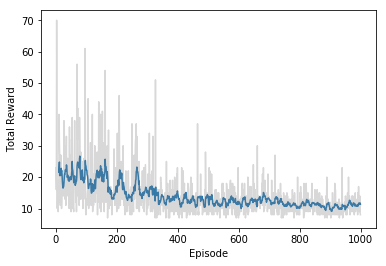

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')